<a href="https://colab.research.google.com/github/debashishnanda/Stock-Market-Prediction/blob/master/Stock_Market_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#STOCK MARKET ANALYSIS AND PREDICTION
Stock market prediction is the act of trying to determine the future value of company stock or other financial object traded on an exchange. If we are able to successfully predict a company’s stock's future price, then it would prove to be a significant profit.

To carry out this prediction, there are many mathematical and statistical tools to learn the variations of stocks over time and predict accordingly. This Learning and prediction on a time series data comes under the domain of Artificial Intelligence where we use **Recurrent Neural Networks** or **LSTM(Long Short Term Memory)** models to take the data coming over time, find and learn specific features and trends in data, and predict accordingly.

In [0]:
#Importing the necessary libraries
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json 
import os
import numpy as np
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler

#Data Collection

---


For Data Collection, the APIs that can be used are - 
* Quandl
* Alpha Vantage
* Xignite
* CoinMarketCap
* Google Finance
* Yahoo Finance

Here we use Alpha Vantage, which offers free APIs in JSON and CSV formats for realtime and historical stock and forex data.

*Reference: https://github.com/RomelTorres/alpha_vantage*

We install it into the colab environment -





In [0]:
!pip install alpha_vantage

  Created wheel for alpha-vantage: filename=alpha_vantage-2.1.2-cp36-none-any.whl size=14690 sha256=e266cd9b44675ec4db4a1b7cd97cc3a444fae6ca1668203684c072786a5f98f8
  Stored in directory: /root/.cache/pip/wheels/bb/22/da/426cbebbe36cf3c0fd433d279f670cadfa27cc3343303cdf36
Successfully built alpha-vantage


In [0]:
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from matplotlib.pyplot import figure

# API key is provided here
key = '0ULBJ2AV3NOV4IV2'
ts = TimeSeries(key)

We will be working on the Stocks of Apple inc.
Whose NASDAQ is AAPL (ticker)
One can change the ticker to view the stocks of the organisation/company they wish.
few common tickers are - 
* AAPL - Apple inc
* ACN - Accenture
* GOOGL - Google
* MSFT - Microsoft

            1. open  2. high  3. low  4. close   5. volume
date                                                      
2019-09-12    224.8   226.42  222.86   223.085  32226669.0


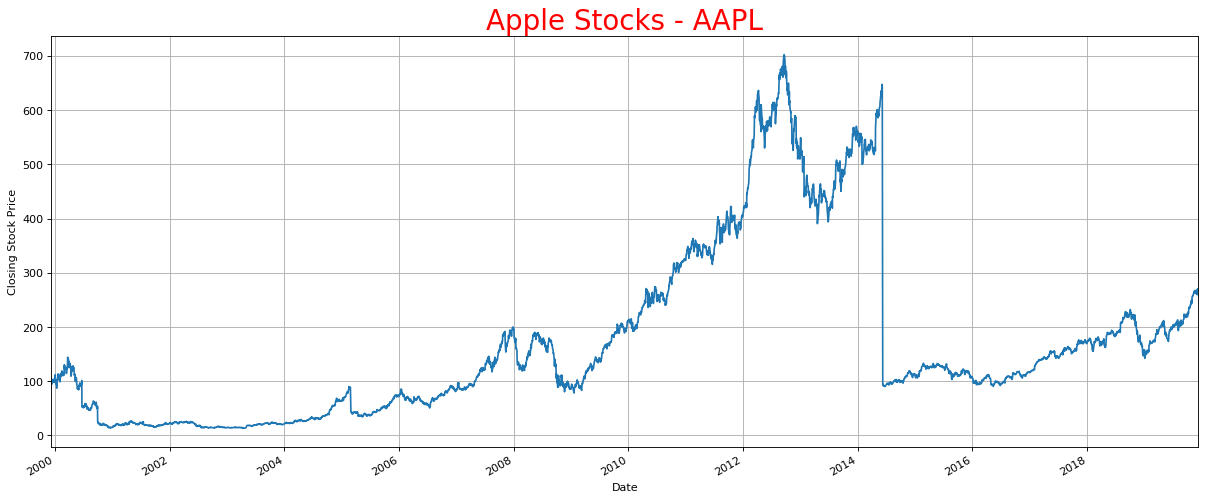

In [0]:
ts = TimeSeries(key, output_format='pandas')
ti = TechIndicators(key)

# aapl_data is a dict, aapl_meta_data also a dict
aapl_data, aapl_meta_data = ts.get_daily(symbol='AAPL', outputsize='full')
print(aapl_data['2019-09-12'])

# aapl_sma is a dict, aapl_meta_sma also a dict
aapl_sma, aapl_meta_sma = ti.get_sma(symbol='AAPL')

# Visualization
figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
aapl_data['4. close'].plot()
plt.tight_layout()
plt.grid()
plt.title("Apple Stocks - AAPL", fontsize=25, color='red')
plt.xlabel('Date')
plt.ylabel('Closing Stock Price')
plt.show()

In [0]:
high_prices = aapl_data.loc[:,'2. high'].as_matrix() #converting it to matrix form [5033,1]
low_prices = aapl_data.loc[:,'3. low'].as_matrix() #converting it to matrix form [5033,1]
mid_prices = (high_prices+low_prices)/2.0 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [0]:
print(mid_prices)

[269.785 267.965 267.855 ... 100.72  104.125 105.935]


In [0]:
print(len(aapl_data)) #size of the data probably more than 5000

5034


# Data Distribution:
Breaking the extracted data to Training and Validation/Test datasets

Training : First 4000

Validation : Rest

In [0]:
train_data = mid_prices[:4000] 
test_data = mid_prices[4000:]

In [0]:
# Scale the data to be between 0 and 1
# normalize both test and train data with respect to training data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

# Data Pre-Processing

---


Different time periods of data have different value ranges, normalizing the whole data would cause prior data to become close to zero and eventually cause loss in feature, hence we break the data in full series to windows. Here I have chosen a window size of 1000. When choosing the window size I made sure it will not be too small else when performing windowed-normalization, it can introduce a break at the very end of each window, as each window is normalized independently. Here 4 data points will be formed [0-1000, 1000-2000, 3000-4000].

In [0]:
smoothing_window_size = 1000
for di in range(0,3000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])




---


**Exponential moving average** smoothing is now performed so that the data will have a smoother curve than the original ragged data

The formula governing it is

{
  
  $EMA = \gamma(x) +(1-\gamma)EMA$

$x = EMA$

}


---



In [0]:
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

# Exponential moving average smoothing is now performed so that the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(4000):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

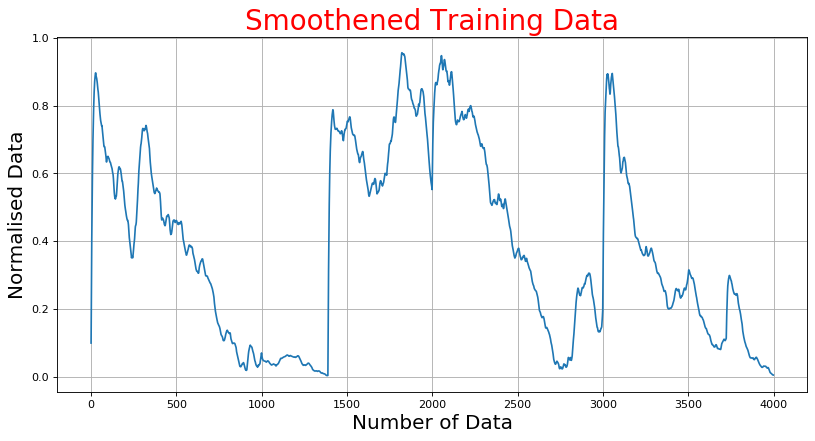

In [0]:
figure(num=None, figsize=(10,5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_data)
plt.tight_layout()
plt.grid()
plt.title("Smoothened Training Data",fontsize=25,color='red')
plt.xlabel('Number of Data',fontsize=18)
plt.ylabel('Normalised Data',fontsize=18)
plt.show()



---


#Defining the Hyper-Parameters -

In [0]:
D = 1                             # Dimensionality of the data. Since our data is 1-D this would be 1
num_unrollings = 50               # Number of time steps to look into the future.
batch_size = 500                  # Number of samples in a batch
num_nodes = [200,200,150]         # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes)         # number of layers
dropout = 0.25                    # dropout amount

tf.reset_default_graph()          # This is important in case you run this multiple times

In [0]:
# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

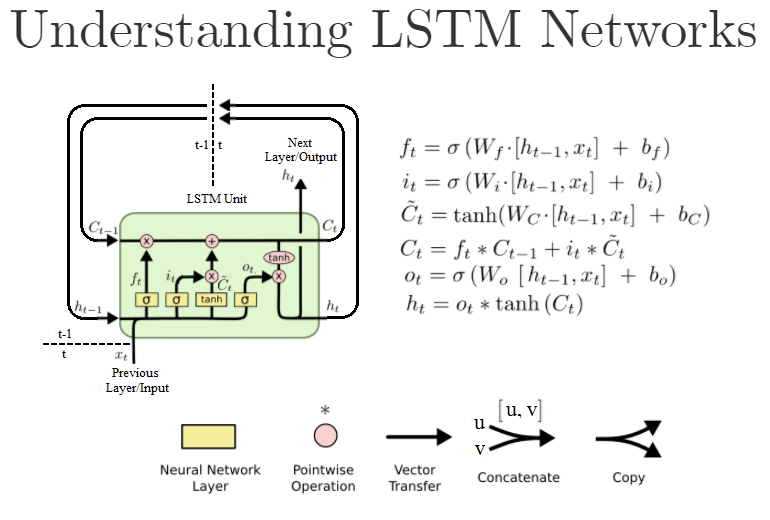

In [0]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]
#Now the dropouts would be implemented
drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

In [0]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Doing several tensor transformations, because the function dynamic_rnn requires the output to be of a specific format.
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)



---


## Code for defining the Training Losses:

* Mean Square Error has been used here
* Decay Rate = 0.5
* Optimizer = Adam_Optimizer


In [0]:
# loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps

print('Training Loss Setup')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay setup')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization Setup')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tComplete')

Training Loss Setup
Learning rate decay setup
TF Optimization Setup
	Complete


In [0]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tComplete')

Defining prediction related TF functions
	Complete




---
## DATA GENERATOR FOR LSTM


---






> We are first going to implement a data generator to train our LSTM. This data generator will have a method called unroll_batches(...) which will output a set of num_unrollings batches of input data obtained sequentially, where a batch of data is of size [batch_size, 1]. Then each batch of input data will have a corresponding output batch of data.


---
*Reference: https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction*




In [0]:
class DataGeneratorSeq(object):
    
    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):
        
        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)
        
        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)
                
            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(1,5)]
            
            self._cursor[b] = (self._cursor[b]+1)%self._prices_length
            
        return batch_data,batch_labels
    
    def unroll_batches(self):
            
        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):
            
            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels
    
    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))
        




---


The Training of our Model and Checking it with the Validation set.
* The number of Epochs = 20
* Learning Rate = 0.0001
* Validation Loss = Mean Square Error(MSE)

The RMSE (Root Mean Squared Error) values are also printed.

In [0]:
epochs = 20
valid_summary = 1 # Interval you make test predictions

n_predict_once = 50 # Number of steps you continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings) 

x_axis_seq = []

# Points you start our test predictions from
test_points_seq = np.arange(4000,len(aapl_data)-50,50).tolist() 

for ep in range(epochs):       
    
    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):
        
        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)
        
        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l
    
    # =================================== Validation =======================================
    if (ep+1) % valid_summary == 0:

      average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))
      
      # The average loss
      if (ep+1)%valid_summary==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))
      
      train_mse_ot.append(average_loss)
            
      average_loss = 0 # reset loss
      
      predictions_seq = []
      
      mse_test_loss_seq = []

      rmse_test_loss_seq = []
      
      # ===================== Updating State and Making Predicitons ========================
      for w_i in test_points_seq:
        
        mse_test_loss = 0.0

        our_predictions = []
        
        if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
          x_axis=[]
        
        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
        for tr_i in range(w_i-num_unrollings+1,w_i-1):
          current_price = all_mid_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
          _ = session.run(sample_prediction,feed_dict=feed_dict)
        
        feed_dict = {}
        
        current_price = all_mid_data[w_i-1]
        
        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)
        
        # Make predictions for this many steps
        # Each prediction uses previous prediciton as it's current input
        for pred_i in range(n_predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)
        
          our_predictions.append(np.asscalar(pred))
        
          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-valid_summary==0:
            # Only calculate x_axis values in the first validation epoch
            x_axis.append(w_i+pred_i)

          mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2
        
        session.run(reset_sample_states)
        
        predictions_seq.append(np.array(our_predictions))
        
        mse_test_loss /= n_predict_once

        mse_test_loss_seq.append(mse_test_loss)         # Mean Squared Error
        rmse_test_loss_seq.append((mse_test_loss)**0.5) # Root Mean Squared Error
        
        if (ep+1)-valid_summary==0:
          x_axis_seq.append(x_axis)
        
      current_test_mse = np.mean(mse_test_loss_seq)
      current_test_rmse = np.mean(rmse_test_loss_seq)
      
      # Learning rate decay logic
      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0
      
      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')
      
      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
      print('\tTest RMSE: %.5f'%np.mean(rmse_test_loss_seq))
      predictions_over_time.append(predictions_seq)
      print('\tEpoch Number: %d Complete' % (ep+1))


print("Training complete: BEST MODEL READY")

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Initialized
Average loss at step 1: 6.889472


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


	Test MSE: 0.01869
	Test RMSE: 0.08643
	Epoch Number: 1 Complete
Average loss at step 2: 2.367826
	Test MSE: 0.00442
	Test RMSE: 0.03426
	Epoch Number: 2 Complete
Average loss at step 3: 0.539334
	Test MSE: 0.00324
	Test RMSE: 0.04707
	Epoch Number: 3 Complete
Average loss at step 4: 0.289987
	Test MSE: 0.00347
	Test RMSE: 0.04156
	Epoch Number: 4 Complete
Average loss at step 5: 0.227696
	Test MSE: 0.00334
	Test RMSE: 0.04436
	Epoch Number: 5 Complete
Average loss at step 6: 0.177405
	Decreasing learning rate by 0.5
	Test MSE: 0.00331
	Test RMSE: 0.04787
	Epoch Number: 6 Complete
Average loss at step 7: 0.178018
	Test MSE: 0.00316
	Test RMSE: 0.04149
	Epoch Number: 7 Complete
Average loss at step 8: 0.162466
	Test MSE: 0.00308
	Test RMSE: 0.04006
	Epoch Number: 8 Complete
Average loss at step 9: 0.161689
	Test MSE: 0.00300
	Test RMSE: 0.03980
	Epoch Number: 9 Complete
Average loss at step 10: 0.164499
	Test MSE: 0.00300
	Test RMSE: 0.03775
	Epoch Number: 10 Complete
Average loss at st



---


# Visualisation of Training and Testing Curves

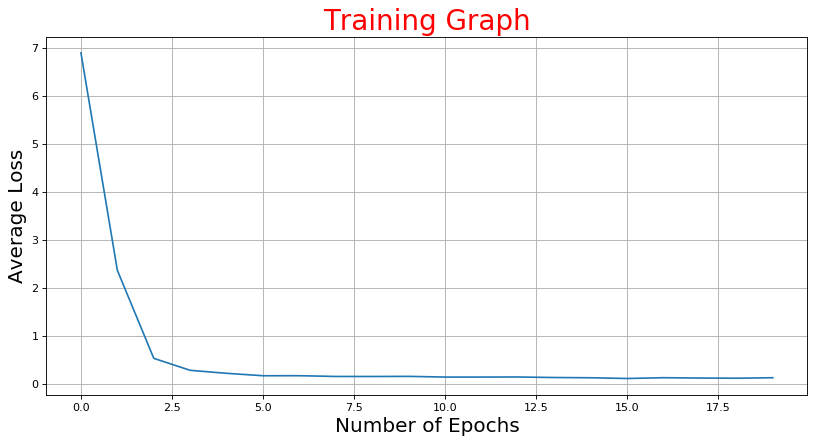

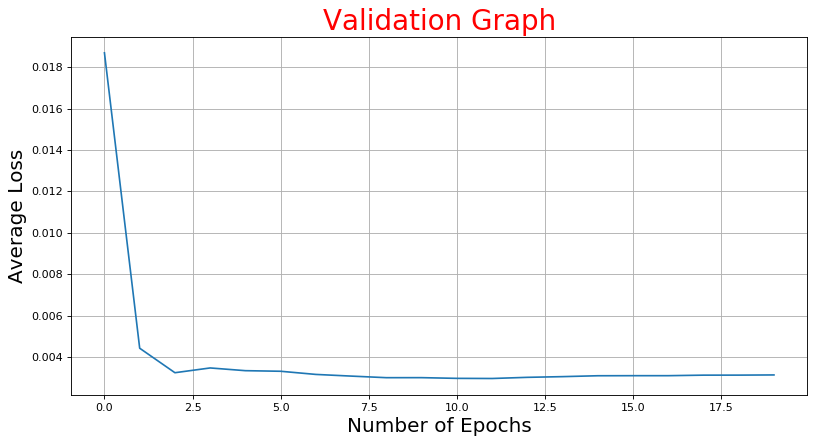

In [0]:
# TRAINING Loss
figure(num=None, figsize=(10,5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_mse_ot)
plt.tight_layout()
plt.grid()
plt.title("Training Graph",fontsize=25,color='red')
plt.xlabel('Number of Epochs',fontsize=18)
plt.ylabel('Average Loss',fontsize=18)
plt.show()

# Validation / Test Loss
figure(num=None, figsize=(10,5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test_mse_ot)
plt.tight_layout()
plt.grid()
plt.title("Validation Graph",fontsize=25,color='red')
plt.xlabel('Number of Epochs',fontsize=18)
plt.ylabel('Average Loss',fontsize=18)
plt.show()

From the above plots the inference we make are - 
* The Minima of the training Curve has been achieved at about 15th Epoch.
* The Validation Loss reaches a minimum at 9 Epochs.
* Both Validation and training loss reach their end point/ converge at 15th Epoch.


---

# Predictions





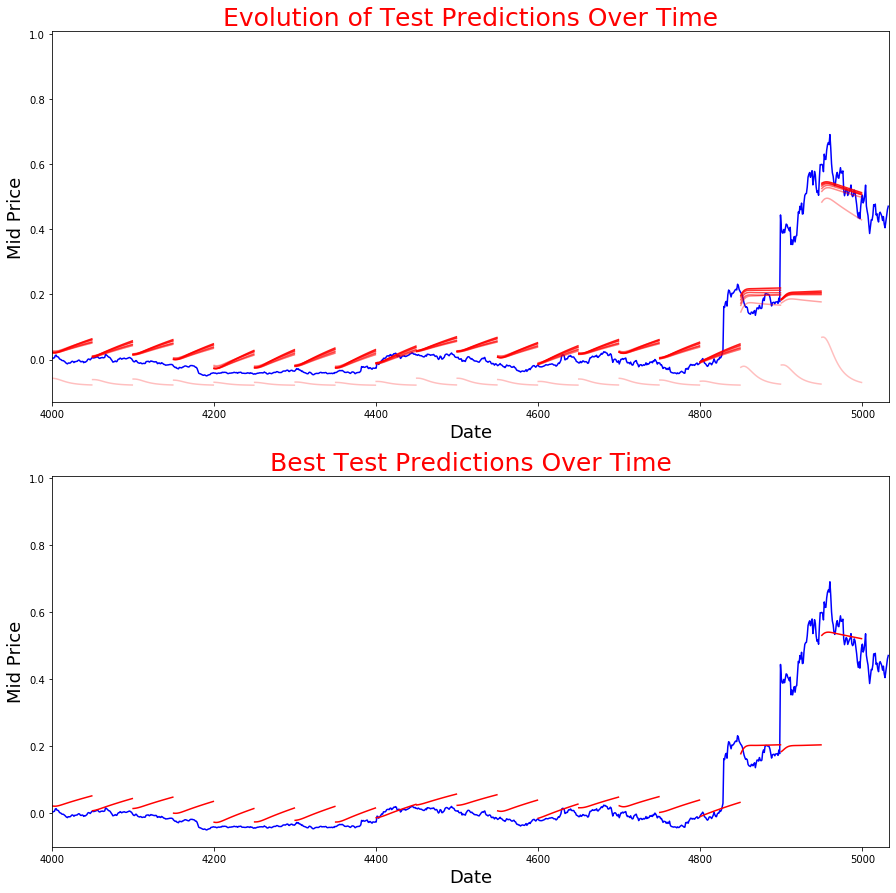

In [0]:
best_prediction_epoch = 10 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (15,15))
plt.subplot(2,1,1)
plt.plot(range(aapl_data.shape[0]),all_mid_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=25, color = 'red')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(4000,len(aapl_data))

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(aapl_data.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')
    
plt.title('Best Test Predictions Over Time',fontsize=25, color = 'red')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(4000,len(aapl_data))
plt.show()

# Conclusion

Observing from the above plots, this LSTM model seems to predict stock price trend almost correctly most of the time. Here the predictions being made are roughly in the range of [0,1], and not the actual stock prices rather the model here is predicting the stock price movement(feature), not the OHLC. 

The LSTM model hyperparameters used here are quite sensitive to the results obtained. Hence Hyper-parameter tuning can prove to be really helpful and come in handy with good predictions. The hyper-parameters that can be tuned to largely affect the results are - 

* The learning rate of the optimizer.
* Number of layers and the number of hidden units in each layer.
* The optimizer (here adam_optimizer showed best convergence).
* Type of the model for example - GRU (Gated Recurrent Unit), Standard LSTM, LSTM with Peepholes.

Here, as Alpha - Vantage has provided 5000+ data of monthly stocks, the data is quite less and hence the predictions can be less accurate. A better way of handling this is to have a separate validation set (apart from the test set) and decay learning rate with respect to performance of the validation set.

###*Reference :*

* *Datacamp Tutorial - https://www.datacamp.com/community/tutorials/lstm-python-stock-market* 
* *Time series predictions: https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction*
* *LSTM tutorials and images: https://colah.github.io/posts/2015-08-Understanding-LSTMs/*
  

###About Me :
* Debashish Nanda
* Chemical Engineering, 3rd year B-Tech.
* IIT(BHU) Varanasi
* LinkedIN: https://www.linkedin.com/in/debashish-nanda-b38164160


